<a href="https://colab.research.google.com/github/tankyven/Data-Science/blob/master/BC3409_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Uploading File from local computer

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [0]:
df = pd.read_csv('DJI 1985 to 2019 for Practical Assessment 1.csv')
df2 = pd.read_csv('historical-libor-rates-chart.csv')

## Exploratory Data Analysis

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29/1/1985,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,30/1/1985,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,31/1/1985,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1/2/1985,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,4/2/1985,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


In [5]:
df2.head()

,date,value,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1/1/86,8.25,8.25,8.25,8.50
1,1/2/86,7.94,7.88,7.88,7.94
2,1/3/86,7.50,7.44,7.44,7.44
3,1/4/86,6.94,6.88,6.88,6.94
4,1/5/86,7.13,7.13,7.19,7.38


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8578 entries, 0 to 8577
Data columns (total 7 columns):
Date         8578 non-null object
Open         8578 non-null float64
High         8578 non-null float64
Low          8578 non-null float64
Close        8578 non-null float64
Adj Close    8578 non-null float64
Volume       8578 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 469.2+ KB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 5 columns):
date          398 non-null object
 value        398 non-null float64
Unnamed: 2    398 non-null float64
Unnamed: 3    398 non-null float64
Unnamed: 4    398 non-null float64
dtypes: float64(4), object(1)
memory usage: 15.6+ KB


In [8]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df2.isnull().sum()

date          0
 value        0
Unnamed: 2    0
Unnamed: 3    0
Unnamed: 4    0
dtype: int64

Both datasets contain no missing values

## Pre-processing

In [0]:
# Remove unnecessary columsn in 1-month LIBOR
df2 = df2.drop(labels=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [0]:
# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df2['date'] = pd.to_datetime(df2['date'], format='%d/%m/%y')

In [0]:
# Extract month & year column
df['Month'] = df['Date'].dt.month
df2['Month'] = df2['date'].dt.month
df['Year'] = df['Date'].dt.year
df2['Year'] = df2['date'].dt.year

In [15]:
# Change headers
df2.columns = ['date', ' LIBOR%', 'Month', 'Year']
df2.head()

,date,LIBOR%,Month,Year
0,1986-01-01,8.25,1,1986
1,1986-02-01,7.94,2,1986
2,1986-03-01,7.50,3,1986
3,1986-04-01,6.94,4,1986
4,1986-05-01,7.13,5,1986


In [0]:
# Merge datasets & drop unnecessary columns
new_df = pd.merge(df, df2,  how='inner', left_on=['Month','Year'], right_on = ['Month','Year'])
new_df = new_df.drop(labels=['Month','Year','date','Adj Close'],axis=1)

In [120]:
# Add SMAs
new_df['SMA_100'] = new_df['Close'].rolling(window=100, min_periods=1, center=False).mean()
new_df['SMA_20'] = new_df['Close'].rolling(window=20, min_periods=1, center=False).mean()

# Add EMAs
new_df['EMA_26'] = pd.ewma(new_df['Close'], span=26)
new_df['EMA_12'] = pd.ewma(new_df['Close'], span=12)

# Add MACD
new_df['MACD'] = (new_df['EMA_12'] - new_df['EMA_26'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  


In [121]:
len(new_df)

8324

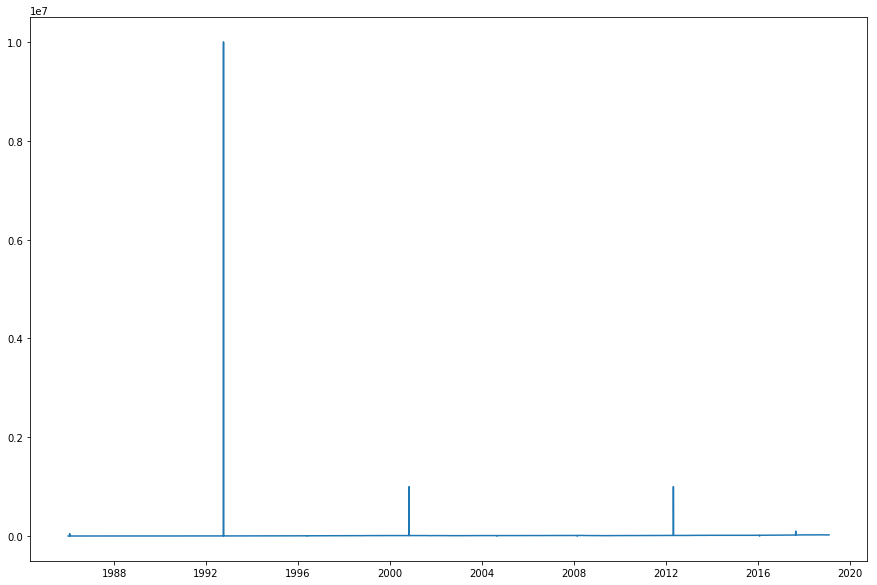

In [122]:
# Plot closing price
plt.figure(figsize = (15,10))
plt.plot(new_df['Date'], new_df['Close'])

Shows 5 outliers that need to be removed.

In [123]:
# Remove outliers
new_df = new_df.drop([17,1710,3751,6641,7959],axis=0)
len(new_df)

8319

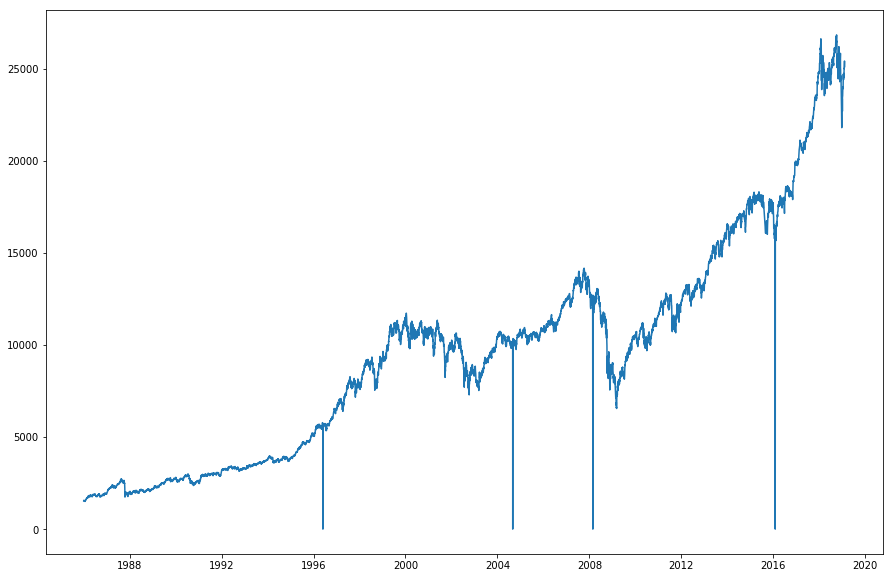

In [124]:
# Plot closing price
plt.figure(figsize = (15,10))
plt.plot(new_df['Date'], new_df['Close'])

Shows 4 outliers that need to be removed.

In [0]:
# Remove outliers where Close = 0
new_df = new_df.drop([2631,4709,5585,7562],axis=0)

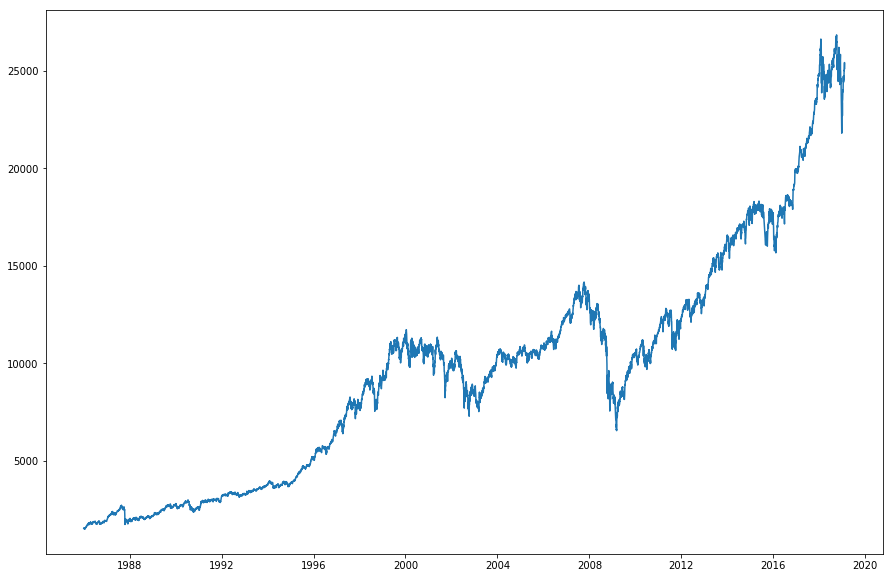

In [126]:
# Plot closing price
plt.figure(figsize = (15,10))
plt.plot(new_df['Date'], new_df['Close'])

In [0]:
df = df.reset_index(drop=True)

## Modelling

### SMA

### LSTM

In [0]:
#setting index
new_df.index = new_df.Date
new_df.drop(['Date', 'Open', 'High', 'Low'], axis=1, inplace=True)

In [130]:
new_df.head()

,Close,Volume,LIBOR%,SMA_100,SMA_20,EMA_26,EMA_12,MACD
Date,,,,,,,,
1986-01-02,1537.729980,10660000,8.25,1537.729980,1537.729980,1537.729980,1537.729980,0.000000
1986-01-03,1549.199951,10460000,8.25,1543.464966,1543.464966,1543.685542,1543.942881,0.257339
1986-01-06,1547.589966,11000000,8.25,1544.839966,1544.839966,1545.088364,1545.366339,0.277976
1986-01-07,1565.709961,15170000,8.25,1550.057465,1550.057465,1550.853261,1551.788025,0.934764
1986-01-08,1526.609985,20630000,8.25,1545.367969,1545.367969,1545.231145,1544.947242,-0.283903


In [149]:
test = new_df[['Close','Volume',' LIBOR%','MACD']]
test.head()

,Close,Volume,LIBOR%,MACD
Date,,,,
1986-01-02,1537.729980,10660000,8.25,0.000000
1986-01-03,1549.199951,10460000,8.25,0.257339
1986-01-06,1547.589966,11000000,8.25,0.277976
1986-01-07,1565.709961,15170000,8.25,0.934764
1986-01-08,1526.609985,20630000,8.25,-0.283903


In [155]:
train[1]

array([1.54919995e+03, 1.04600000e+07, 8.25000000e+00, 2.57339093e-01])

In [0]:
# Ensures that 2018 onwards used for validation
dataset = test.values
train = dataset[0:8046,:]
valid = dataset[8046:,:]


#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(30,len(train)):
    x_train.append(scaled_data[i-30:i])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],4))

In [163]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(x_train.shape[1],4)))
model.add(LSTM(units=32))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=2)

Epoch 1/3
 - 834s - loss: 3.9898e-04
Epoch 2/3
 - 827s - loss: 9.8352e-05
Epoch 3/3
 - 825s - loss: 7.0890e-05


In [0]:
#predicting 269 values, using past 30 from the train data
inputs = test[len(test) - len(valid) - 30:].values
# inputs = inputs.reshape(-1,30)
inputs  = scaler.transform(inputs)

In [0]:
X_test = []
for i in range(30,inputs.shape[0]):
    X_test.append(inputs[i-30:i])
X_test = np.array(X_test)

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],4))

In [219]:
closing_price.shape

(269, 1)

In [0]:
closing_price = model.predict(X_test)
# Get something which has as many features as dataset
closing_price_extended = np.zeros((len(closing_price),4))
# Put the predictions there
closing_price_extended[:,0] = closing_price.reshape(269)
# # Inverse transform it and select the 1st column.
closing_price = scaler.inverse_transform(closing_price_extended)[:,0]

## Results

### RMSE

In [232]:
rms=np.sqrt(np.mean(np.power((valid[:,0]-closing_price),2)))
rms

450.95109786616905

### Plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


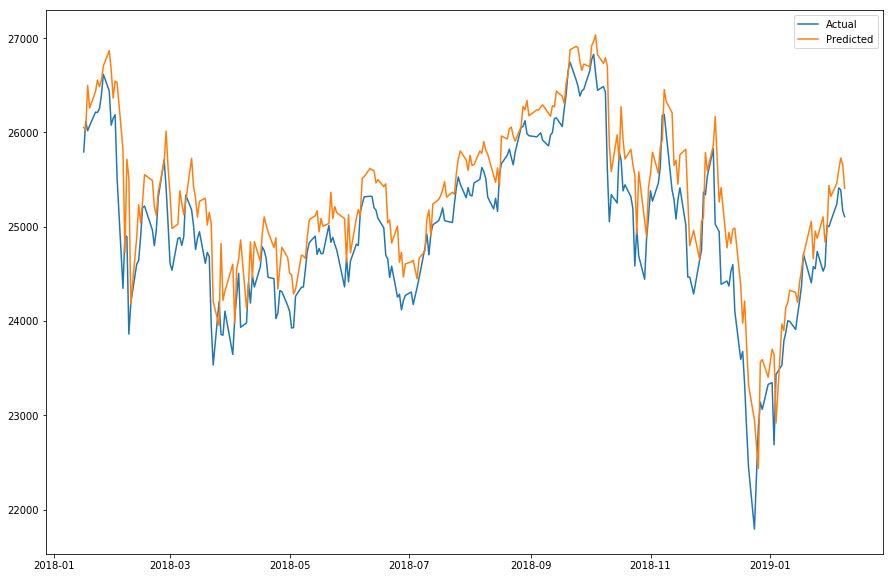

In [239]:
plt.figure(figsize=(15,10))
train = new_df[:8046]
valid = new_df[8046:]
valid['Predictions'] = closing_price
# plt.plot(train['Close'])
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label = 'Predicted')
plt.legend()